In [1]:
import sys
sys.path.append('../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.client import device_lib
print([dev.name for dev in device_lib.list_local_devices()])

['/device:CPU:0', '/device:GPU:0']


In [2]:
import numpy as np
import tensorflow as tf
from lib.encoding import decode_board, encode_board

# Load dataset

In [3]:
# read file
dataset = tf.data.Dataset.list_files('../data/dataset/*.bin', shuffle=True, seed=42)
dataset = tf.data.FixedLengthRecordDataset(dataset, record_bytes=3 * 12 * 8)
dataset = dataset.map(lambda s: tf.reshape(tf.io.decode_raw(s, tf.int64), (3, 12)))
dataset = dataset.take(800_000)
# dataset = dataset.shuffle(4096)
dataset = dataset.batch(4096).prefetch(32)

In [4]:
batch = next(iter(dataset.take(1)))
batch.shape

TensorShape([4096, 3, 12])

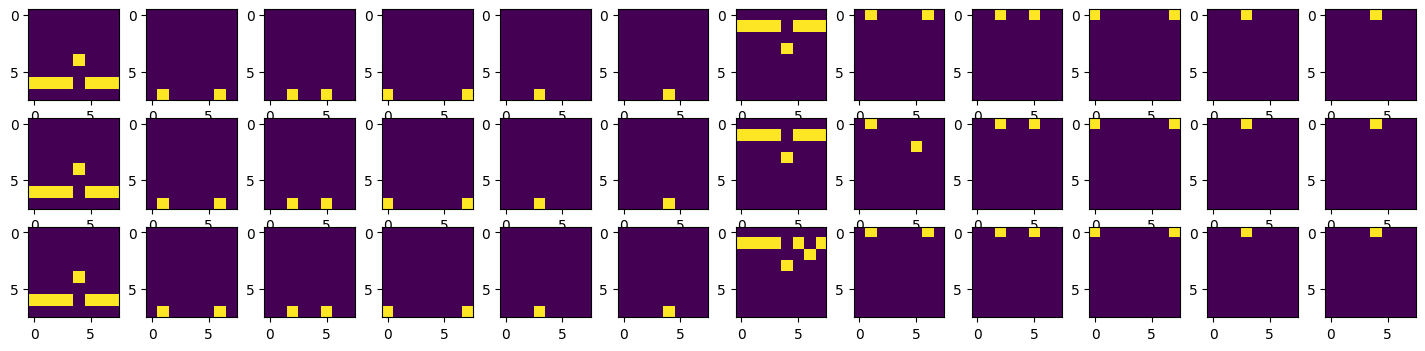

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 12, figsize=(18, 4))
for kind in range(3):
    for layer in range(12):
        axs[kind][layer].imshow(decode_board(batch.numpy()[0]).numpy()[kind].reshape((12,8,8))[layer])
plt.show()

# Train

In [6]:
import keras
from keras.models import Model
from keras.layers import Dense

In [7]:
@keras.saving.register_keras_serializable()
def custom_loss(_y_true, y_pred):
    """
    Compute loss as defined in https://erikbern.com/2014/11/29/deep-learning-for-chess.html
    // sum(p,q,r)logS(f(q)−f(r))+K*log(f(p)+f(q))+K*log(−f(q)−f(p))
    """
    p = y_pred[0]
    q = y_pred[1]
    r = y_pred[2]
    K = 10.0

    a = - tf.math.log(tf.math.sigmoid(q - r))
    b = - K * tf.math.log(tf.math.sigmoid(p + q))
    c = - K * tf.math.log(tf.math.sigmoid(-q - p))

    return a + b + c

def make_chess_model():
    inp = tf.keras.Input(shape=(12,), dtype=tf.int64)
    x = decode_board(inp) # convert 12 ints to 768 floats
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(1)(x)
    return Model(inp, x)

def make_siamese_model(chess_model):
    boards = tf.keras.Input(shape=(3, 12), dtype=tf.int64)

    p_board = boards[:, 0, :]
    q_board = boards[:, 1, :]
    r_board = boards[:, 2, :]

    p = chess_model(p_board)
    q = chess_model(q_board)
    r = chess_model(r_board)

    model = Model(
        inputs=[boards],
        outputs=[p, q, r]
    )
    model.compile('adam', loss=custom_loss, metrics=[])
    return model

chess_model = make_chess_model()
train_model = make_siamese_model(chess_model)
chess_model.summary()
train_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 12, 1)             0         
 )                                                               
                                                                 
 tf.bitwise.bitwise_and (TF  (None, 12, 64)            0         
 OpLambda)                                                       
                                                                 
 tf.math.not_equal (TFOpLam  (None, 12, 64)            0         
 bda)                                                            
                                                                 
 tf.cast (TFOpLambda)        (None, 12, 64)            0         
                                                             

In [8]:
chess_model(batch[0])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.08618897],
       [-0.09361   ],
       [-0.11123157]], dtype=float32)>

In [9]:
train_model.predict(batch)

128/128 [==============================] - 1s 5ms/step


[array([[-0.08618896],
        [-0.08712292],
        [-0.09046108],
        ...,
        [-0.08707104],
        [-0.11156046],
        [-0.04786311]], dtype=float32),
 array([[-0.09361004],
        [-0.03727897],
        [-0.02713398],
        ...,
        [-0.04012894],
        [-0.11379418],
        [-0.06031183]], dtype=float32),
 array([[-0.11123155],
        [-0.04732921],
        [-0.05262522],
        ...,
        [-0.08254088],
        [-0.12171945],
        [-0.04711935]], dtype=float32)]

In [10]:
from time import time
from keras.callbacks import ModelCheckpoint, TensorBoard

ts = int(time())

history = train_model.fit(
    dataset.map(lambda x : (x, tf.constant([0.0]))),
    epochs=9999,
    callbacks=[
        ModelCheckpoint(f"checkpoints/{ts}" + "/model-{epoch:02d}-{loss:.2f}.keras"),
        TensorBoard(log_dir=f"./logs/{ts}", write_graph=False)
    ]
)

Epoch 1/9999


I0000 00:00:1706300225.740821   20973 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 35s 148ms/step - loss: 44.2652 - model_loss: 14.7530 - model_1_loss: 14.7513 - model_2_loss: 14.7609
Epoch 2/9999
196/196 [==============================] - 98s 503ms/step - loss: 43.6770 - model_loss: 14.5588 - model_1_loss: 14.5588 - model_2_loss: 14.5594
Epoch 3/9999
196/196 [==============================] - 77s 390ms/step - loss: 43.6732 - model_loss: 14.5577 - model_1_loss: 14.5576 - model_2_loss: 14.5579
Epoch 4/9999
196/196 [==============================] - 30s 154ms/step - loss: 43.6742 - model_loss: 14.5668 - model_1_loss: 14.5527 - model_2_loss: 14.5547
Epoch 5/9999
196/196 [==============================] - 31s 157ms/step - loss: 43.6712 - model_loss: 14.5570 - model_1_loss: 14.5571 - model_2_loss: 14.5570
Epoch 6/9999
 11/196 [>.............................] - ETA: 31s - loss: 43.6695 - model_loss: 14.5559 - model_1_loss: 14.5565 - model_2_loss: 14.5571

KeyboardInterrupt: 